In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10 --xla_cpu_enable_fast_math=true'

import jax
print(jax.devices())

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import jax.numpy as jnp
import jax 
from jax import grad, vmap
jax.config.update("jax_enable_x64", True)




import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.linalg as sla

import fisher_jim_tgr_v3 as lib
import pycbc.conversions

import astropy.units as u
from astropy import constants as const

Ms = (u.Msun * const.G / const.c**3 ).si.value
from datetime import datetime
datestr = datetime.now().strftime('%m-%d-%y')

import sys
import matplotlib as mpl

# Clear matplotlib from sys.modules
for module in list(sys.modules.keys()):
    if module.startswith("matplotlib"):
        del sys.modules[module]

import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")
%config InlineBackend.figure_format = 'retina'
obj = lib.Fisher(fmin = 20, fmax = 2000, n_freq = 4000.)

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


In [ ]:
full_str = ["M_c", "eta", "d_L", "ra", "dec", "iota", "psi", "t_c", "phase_c", "zco", "rng", "Mc_source", "snr_H1", "snr_L1", "snr_V1", "snr_t"]
names = full_str[0:9]
# data = np.loadtxt("data/events.txt")
data = jnp.array(np.loadtxt("data/5-year-data-O3/5-year-data-O3-events.txt"))
# data = jnp.array(nnp.loadtxt("data/5-year-data-CE/5-year-data-CE-events.txt"))



data_150914 = np.array(data[1])
data_150914[0] = 3
q  = 0.79
data_150914[1] = q/(1+q)**2
data_150914[2] = 390/10

idx = '150914'
if idx=='150914':
    data_150914 = np.array(data[1])
    data_150914[0] = 10
    q  = 0.79
    data_150914[1] = q/(1+q)**2
    data_150914[2] = 390
    dat = jnp.array(data_150914)
elif idx=='170817':
    data_150914 = np.array(data[1])
    data_150914[0] = 3
    q  = 0.79
    data_150914[1] = q/(1+q)**2
    data_150914[2] = 390/10
    dat = jnp.array(data_150914)

red_param = dict(zip(names, jnp.array(dat).T))


epsilon = jnp.array(1e-6)
for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
    red_param[key] = epsilon
zero_vector = jnp.array(0.)
for key in ['gmst', 'epoch']:
    red_param[key] = zero_vector

x = red_param.copy()
x['s1_z'] = 0.
x['s1_x'] = 0.

prec_pe = True
if prec_pe:
    i = None
else:
    i = -2
hgr = obj.get_h_gr(x)
dhgr = obj.get_dh_gr(x)
paramgr = obj.paramdiffgr.copy()[:i]
paramgr_latex = obj.paramdiffgr_latex.copy()[:i]
freqs = obj.freqs.copy()
dets = ["H1", "L1", "V1"]

In [27]:
def make_Dh_ppe(kinj, dphik, x, norm_dh = False):
    Dh = {}
    dpsi_inj = dphik*lib.get_dpsi_ppe(obj.freqs, x, kinj)
    for d in dets:
        Dh[d] = 1j * dpsi_inj * hgr[d] 
    if norm_dh:
        normarr = [lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in dets]
        norm = np.sum(normarr)**(1/2)
        dpsi_inj = dpsi_inj/norm
        for d in dets:
            Dh[d] = Dh[d]/norm
    return Dh

def make_Dh_ppe_norm(kinj, x, snr=1):
    norm = lib.get_dpsi_ppe(20, x, kinj)- lib.get_dpsi_ppe(6000, x, kinj)
    dphik_guess = 1/norm
    Dh = make_Dh_ppe(kinj, dphik_guess, x, norm_dh = True)
    for d in dets:
        Dh[d] = Dh[d]/snr
    return Dh

def compute_Dh_ppek_perp(k, dh, x, param, cov):
    Dh = make_Dh_ppe_norm(k, x)
    if k==5:
        for d in dets:
            Dh[d] = Dh[d]*0
    bias_ip = obj.compute_biasip_raw(dh, Dh, x, param)
    dx_bias = np.array(cov @ bias_ip)
    dx_stat = np.diagonal(np.array(cov ))**(1/2)

    idx_par = obj.idx_par.copy()
    log_flag = obj.log_flag.copy()

    for p in filter(log_flag.__getitem__, param):
        i = idx_par[p]
        dx_bias[i] *= x[p]
        dx_stat[i] *= x[p]

    dhpara, dhperp = {}, {}
    for d in dets:
        dhpara[d] = sum((dx_bias[idx_par[p]] * dh[d][p] for p in paramgr), jnp.zeros_like(freqs))
        dhperp[d] = Dh[d] - dhpara[d]
    
    if k!=5:
        dperpnorm = [lib.innprod(dhperp[d], dhperp[d], obj.psdO3, obj.freqs) for d in dets]
        dperpnorm = np.sum(dperpnorm)**(1/2)

        for d in dets:
            dhperp[d] = dhperp[d] / dperpnorm
            Dh[d] = Dh[d] / dperpnorm
    return dhperp, Dh



dh = obj.get_dh_gr(x)
fi = obj.compute_fisher_raw(dhgr, x, paramgr)
# kk = np.array(list(obj.k2str.keys()))
cov = jnp.linalg.inv(fi)
res = {}
resDh = {}
kk = np.array(list(obj.k2str.keys()))
for k in kk:
    dhperp, Dh = compute_Dh_ppek_perp(k, dhgr, x, paramgr, cov)
    res[obj.k2str[k]] = dhperp
    resDh[obj.k2str[k]] = Dh

In [28]:
def compute_H_svd(all_dets=True,perp=True):
    rows = []
    for key in obj.str2k:
        if obj.str2k[key] !=5:
            if perp:
                detectors = res[key]
            else:
                detectors = resDh[key]
            if all_dets:
                concatenated = np.concatenate([weight*detectors["H1"], weight*detectors["L1"], weight*detectors["V1"]])
            else:
                concatenated = np.concatenate([weight*detectors["H1"]])
            rows.append(concatenated)
    return rows

df = np.diff(obj.freqs)
delta_f = np.empty_like(obj.freqs, dtype=float)
delta_f[1:-1] = (df[:-1] + df[1:]) / 2.0
delta_f[0] = df[0]
delta_f[-1] = df[-1]
weight = np.sqrt(4*delta_f/obj.psdO3)

Hperp = compute_H_svd()
Hperpsingle = compute_H_svd(all_dets=False)
HDh = compute_H_svd(perp=False)


/tmp/ipykernel_1297186/275978713.py:20: RuntimeWarning: invalid value encountered in divide
  svdmain = Vh[0] / weight / np.abs(hgr["H1"]) * s[0] /3
/tmp/ipykernel_1297186/275978713.py:33: RuntimeWarning: invalid value encountered in divide
  dpsi_svd = Vh[i] / weight / np.abs(hgr["H1"]) * s[i] /3


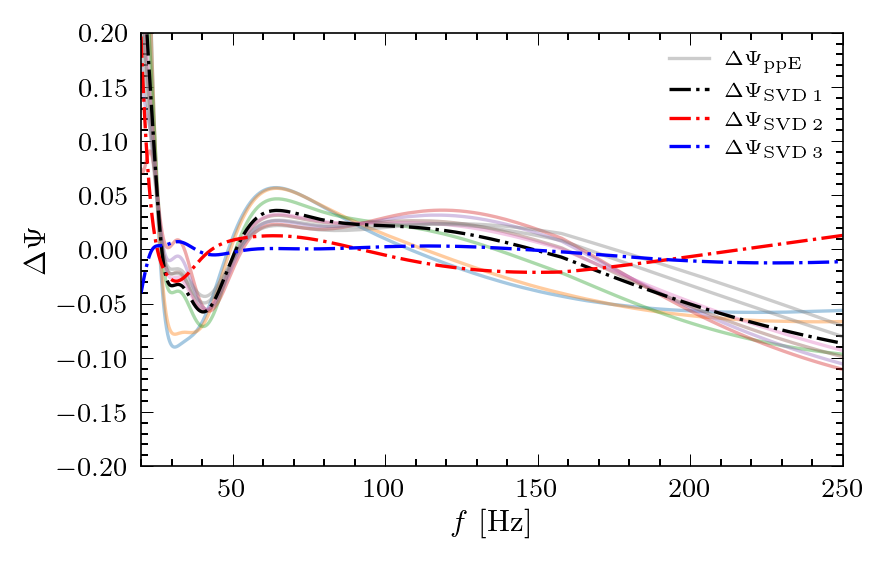

In [34]:
H = np.array(Hperpsingle)


Hp = np.imag(H * np.exp(-1j*np.angle(hgr["H1"])))
U, s, Vh = np.linalg.svd(Hp, full_matrices=False)


kkplt = [-2,-1,0,1, 2,3,4,6, 7]

for k in kkplt:
    # line, = plt.plot(obj.freqs,np.real(resDh[obj.k2str[k]]["H1"] / hgr["H1"]/1j), label=rf"$\Delta \Psi_{{ {k:d} }}$")

    if k!=7:
        plt.plot(obj.freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j), alpha=0.4)
    else:
        plt.plot(obj.freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j), alpha=0.4, c = "gray", label=r"$\Delta \Psi_\mathrm{ppE }$")

cc = ["k","r","b","gray","m"]

svdmain = Vh[0] / weight / np.abs(hgr["H1"]) * s[0] /3
ref = np.real(res[obj.k2str[3]]["H1"] / hgr["H1"]/1j) # some physically known or previously fixed shape
mask = ~np.isnan(svdmain) & ~np.isnan(ref)
if not np.any(mask):
    svd_sign = 1
else:
    if np.dot(svdmain[mask], ref[mask]) < 0:
        svd_sign = -1
    else:
        svd_sign = 1

norm = np.sqrt(obj.freqs)
for i in range(3):
    dpsi_svd = Vh[i] / weight / np.abs(hgr["H1"]) * s[i] /3
    # vals = norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j
    # ang2 =  -np.real(norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j)
    plt.plot(obj.freqs, svd_sign*dpsi_svd, label=rf"$\Delta \Psi_{{\mathrm{{SVD}}\, {i+1:d} }}$",ls = "-.",c=cc[i])

    

plt.xlim(20, 250)
plt.ylim(-0.2,0.2)
plt.legend(loc=1)

plt.xlabel(r"$f$ [Hz]") 
plt.ylabel(r"$\Delta \Psi$") 
# plt.savefig(datestr + "-svd-example-refactored.pdf", bbox_inches='tight', pad_inches=0) 

plt.show()

In [35]:
import ipywidgets as widgets
from ipywidgets import interactive

full_str = ["M_c", "eta", "d_L", "ra", "dec", "iota", "psi", "t_c", "phase_c", "zco", "rng", "Mc_source", "snr_H1", "snr_L1", "snr_V1", "snr_t"]
names = full_str[0:9]
# data = np.loadtxt("data/events.txt")
data = jnp.array(np.loadtxt("data/5-year-data-O3/5-year-data-O3-events.txt"))
dets = None
hgr = None
freqs = None

def make_Dh_ppe(kinj, dphik, x, norm_dh = False):
    Dh = {}
    dpsi_inj = dphik*lib.get_dpsi_ppe(obj.freqs, x, kinj)
    for d in dets:
        Dh[d] = 1j * dpsi_inj * hgr[d] 
    if norm_dh:
        normarr = [lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in dets]
        norm = np.sum(normarr)**(1/2)
        dpsi_inj = dpsi_inj/norm
        for d in dets:
            Dh[d] = Dh[d]/norm
    return Dh

def make_Dh_ppe_norm(kinj, x, snr=1):
    norm = lib.get_dpsi_ppe(20, x, kinj)- lib.get_dpsi_ppe(6000, x, kinj)
    dphik_guess = 1/norm
    Dh = make_Dh_ppe(kinj, dphik_guess, x, norm_dh = True)
    for d in dets:
        Dh[d] = Dh[d]/snr
    return Dh

def compute_Dh_ppek_perp(k, dh, x, param, cov):
    Dh = make_Dh_ppe_norm(k, x)
    if k==5:
        for d in dets:
            Dh[d] = Dh[d]*0
    bias_ip = obj.compute_biasip_raw(dh, Dh, x, param)
    dx_bias = np.array(cov @ bias_ip)
    dx_stat = np.diagonal(np.array(cov ))**(1/2)

    idx_par = obj.idx_par.copy()
    log_flag = obj.log_flag.copy()

    for p in filter(log_flag.__getitem__, param):
        i = idx_par[p]
        dx_bias[i] *= x[p]
        dx_stat[i] *= x[p]

    dhpara, dhperp = {}, {}
    for d in dets:
        dhpara[d] = sum((dx_bias[idx_par[p]] * dh[d][p] for p in param), jnp.zeros_like(freqs))
        dhperp[d] = Dh[d] - dhpara[d]
    
    if k!=5:
        dperpnorm = [lib.innprod(dhperp[d], dhperp[d], obj.psdO3, obj.freqs) for d in dets]
        dperpnorm = np.sum(dperpnorm)**(1/2)

        for d in dets:
            dhperp[d] = dhperp[d] / dperpnorm
            Dh[d] = Dh[d] / dperpnorm
    return dhperp, Dh




def interactive_plot(Mc=30.0, q=0.79, chi_eff=1e-6, chi_p=1e-6, prec_pe=True):
    def compute_H_svd(all_dets=True,perp=True):
        rows = []
        for key in obj.str2k:
            if obj.str2k[key] !=5:
                if perp:
                    detectors = res[key]
                else:
                    detectors = resDh[key]
                if all_dets:
                    concatenated = np.concatenate([weight*detectors["H1"], weight*detectors["L1"], weight*detectors["V1"]])
                else:
                    concatenated = np.concatenate([weight*detectors["H1"]])
                rows.append(concatenated)
        return rows
    global hgr, freqs, dets
    dets = ["H1","L1","V1"]
    # set Mc and update dependent params
    # q = 0.79
    eta = q/(1+q)**2
    d_L = 390 

    data_150914 = np.array(data[1])  # base template
    data_150914[0] = Mc
    data_150914[1] = eta
    data_150914[2] = d_L
    dat = jnp.array(data_150914)
    
    red_param = dict(zip(names, jnp.array(dat).T))
    for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
        red_param[key] = jnp.array(1e-6)
    for key in ['gmst', 'epoch']:
        red_param[key] = jnp.array(0.)

    red_param['s1_z'] =  jnp.array((chi_eff * (1 + q)))
    red_param['s1_x'] =  jnp.array(chi_p)
    x = red_param.copy()
    # x['s1_z'] = 0.
    # x['s1_x'] = 0.



    i = None if prec_pe else -2

    # Recompute GR waveform and derivatives
    hgr = obj.get_h_gr(x)
    dhgr = obj.get_dh_gr(x)
    paramgr = obj.paramdiffgr.copy()[:i]
    paramgr_latex = obj.paramdiffgr_latex.copy()[:i]
    freqs = obj.freqs.copy()

    dh = obj.get_dh_gr(x)
    fi = obj.compute_fisher_raw(dhgr, x, paramgr)
    cov = jnp.linalg.inv(fi)
    
    res = {}
    resDh = {}
    kk = np.array(list(obj.k2str.keys()))
    for k in kk:
        dhperp, Dh = compute_Dh_ppek_perp(k, dhgr, x, paramgr, cov)
        res[obj.k2str[k]] = dhperp
        resDh[obj.k2str[k]] = Dh

    df = np.diff(obj.freqs)
    delta_f = np.empty_like(obj.freqs, dtype=float)
    delta_f[1:-1] = (df[:-1] + df[1:]) / 2.0
    delta_f[0] = df[0]
    delta_f[-1] = df[-1]
    weight = np.sqrt(4 * delta_f / obj.psdO3)
    H = np.array(compute_H_svd(all_dets=False))  # just H1 for SVD
    Hp = np.imag(H * np.exp(-1j * np.angle(hgr["H1"])))
    U, s, Vh = np.linalg.svd(Hp, full_matrices=False)

    kkplt = [-2,-1,0,1,2,3,4,6,7]
    for k in kkplt:
        if k != 7:
            plt.plot(freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j), alpha=0.4)
        else:
            plt.plot(freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j), alpha=0.4, color="gray", label=r"$\Delta \Psi_\mathrm{ppE}$")
    # SVD Modes
    with np.errstate(invalid='ignore', divide='ignore'):
        svdmain = Vh[0] / weight / np.abs(hgr["H1"]) * s[0] /3
    ref = np.real(res[obj.k2str[3]]["H1"] / hgr["H1"]/1j) # some physically known or previously fixed shape
    mask = ~np.isnan(svdmain) & ~np.isnan(ref)
    if not np.any(mask):
        svd_sign = 1
    else:
        if np.dot(svdmain[mask], ref[mask]) < 0:
            svd_sign = -1
        else:
            svd_sign = 1
    cc = ["k","r","b","gray","m"]
    for i in range(3):
        with np.errstate(invalid='ignore', divide='ignore'):
            dpsi_svd = Vh[i] / weight / np.abs(hgr["H1"]) * s[i] /3
        plt.plot(freqs, svd_sign*dpsi_svd, label=rf"$\Delta \Psi_{{\mathrm{{SVD}}\, {i+1:d} }}$", ls="-.", c=cc[i])

    plt.xlim(20, 250)
    plt.ylim(-0.2, 0.2)
    plt.legend(loc="upper right")
    plt.xlabel(r"$f$ [Hz]")
    plt.ylabel(r"$\Delta \Psi$")
    plt.grid(True)
    plt.show()


controls = widgets.VBox([
    widgets.FloatSlider(value=30.0, min=1.0, max=100.0, step=1.0, description=r'$\mathcal{M}_c$'),
    widgets.FloatSlider(value=0.79, min=0.01, max=0.99, step=0.01, description=r'$q$'),
    widgets.FloatSlider(value=1e-6, min=1e-6, max=0.99, step=0.01, description=r'$\chi_eff$'),
    widgets.FloatSlider(value=1e-6, min=1e-6, max=0.99, step=0.01, description=r'$\chi_p$'),
    widgets.Checkbox(value=True, description='Prec PE')
])

out = widgets.interactive_output(interactive_plot, {
    'Mc': controls.children[0],
    'q': controls.children[1],
    'chi_eff': controls.children[2],
    'chi_p': controls.children[3],
    'prec_pe': controls.children[4]
})

display(widgets.HBox([controls, out]))
